<a href="https://colab.research.google.com/github/Zhengro/Face-Segmentation-and-Pixelation/blob/master/Face_Segmentation_and_Pixelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install libraries

In [0]:
!pip install -q imgaug
!pip install -q Cython
!pip install -q pycocotools

Clone repo

In [0]:
!git clone -q https://github.com/matterport/Mask_RCNN

# **!!! Upload *face_detection_200.json* into the folder Mask R-CNN at this point**

# Mask R-CNN - Train on the Face Dataset

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import itertools
import logging
import json
from collections import OrderedDict
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import urllib.request
import skimage.draw 

os.chdir('/content/Mask_RCNN/samples')
# Root directory of the project
ROOT_DIR = os.path.abspath('../')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


## Download Images

In [0]:
!mkdir /content/Mask_RCNN/train
!mkdir /content/Mask_RCNN/val

In [0]:
def subsample(N, n):

    idx = np.arange(0, N)
    np.random.shuffle(idx)
    idx_train = idx[:n]
    idx_val = idx[n:]
    return idx_train, idx_val

dataset_dir = '/content/Mask_RCNN'
annotations = json.load(open(os.path.join(dataset_dir, 'face_detection_200.json')))
annotations = list(annotations.values())  # don't need the dict keys

In [0]:
N = len(annotations)
n = int(0.9*N)
idx_train, idx_val = subsample(N, n)

# write train data file and download pictures
train_dataset_dir = '/content/Mask_RCNN/train'
os.chdir(train_dataset_dir)
train_data = [annotations[int(i)] for i in idx_train]
with open('face_detection.json', 'w') as outfile:
    json.dump(train_data, outfile)

train_anno = json.load(open(os.path.join(train_dataset_dir, 'face_detection.json')))
for a in train_anno:
     filename = a['filename'].split('/')[-1]
     urllib.request.urlretrieve(a['filename'], filename)

# write val data file and download pictures
val_dataset_dir = '/content/Mask_RCNN/val'
os.chdir(val_dataset_dir)
val_data = [annotations[int(i)] for i in idx_val]
with open('face_detection.json', 'w') as outfile:
    json.dump(val_data, outfile)

val_anno = json.load(open(os.path.join(val_dataset_dir, 'face_detection.json')))
for a in val_anno:
     filename = a['filename'].split('/')[-1]
     urllib.request.urlretrieve(a['filename'], filename)

os.chdir('/content/Mask_RCNN/samples')

## Set up Configurations

In [0]:
class FaceConfig(Config):
    """Configuration for training on the face dataset.
       Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = 'face'
    
    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + face

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    # Input image resizing
    # Generally, use the 'square resizing mode for training and predicting
    # and it should work well in most cases. In this mode, images are scaled
    # up such that the small side is = IMAGE_MIN_DIM, but ensuring that the
    # scaling doesn't make the long side > IMAGE_MAX_DIM. Then the image is
    # padded with zeros to make it a square so multiple images can be put
    # in one batch.
    IMAGE_RESIZE_MODE = 'square'
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024

config = FaceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Notebook Preferences

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Define Dataset Class

In [0]:
class FaceDataset(utils.Dataset):
  
  def load_face(self, dataset_dir, subset):
    """Load a subset of the Face dataset.
    dataset_dir: Root directory of the dataset.
    subset: Subset to load: train or val
    """
    # Add classes. We have only one class to add.
    self.add_class('Face', 1, 'Face')
    
    # Train or validation dataset
    assert subset in ['train', 'val']
    dataset_dir = os.path.join(dataset_dir, subset)
    
    annotations = json.load(open(os.path.join(dataset_dir, 'face_detection.json')))
      
    # Skip unannotated images
    annotations = [a for a in annotations if a['regions']]
    
    # Add images
    for a in annotations:
      polygons = [r['shape_attributes'] for r in a['regions']]
      
      filename = a['filename'].split('/')[-1]
      image_path = os.path.join(dataset_dir, filename)
      
      image = skimage.io.imread(image_path)
      height, width = image.shape[:2]
      
      self.add_image('Face', 
              image_id=a['filename'],
              path=image_path,
              width=width, height=height,
              polygons=polygons)
    
    
  def load_mask(self, image_id):
      """Generate instance masks for an image.
      Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
      """
      
      # If not a Face dataset image, delegate to parent class.
      image_info = self.image_info[image_id]
      if image_info['source'] != 'Face':
        return super(self._class_, self).load_mask(image_id)
      
      # Convert polygons to a bitmap mask of shape
      # [height, width, instance_count]
      info = self.image_info[image_id]
      mask = np.zeros([info['height'], info['width'], len(info['polygons'])], dtype=np.uint8)
      for i, p in enumerate(info['polygons']):
        # Get indexes of pixels inside the polygon and set them to 1
        rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
        mask[rr, cc, i] = 1
      
      return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    
  def image_reference(self, image_id):
      """Return the path of the image."""
      info = self.image_info[image_id]
      if info['source'] == 'Face':
        return info['path']
      else: 
        super(self._class_, self).image_reference(image_id)


## Verify the Dataset

### Dataset Statistics

In [0]:
dataset_dir = '/content/Mask_RCNN'

# train dataset
dataset_train = FaceDataset()
dataset_train.load_face(dataset_dir, 'train')
dataset_train.prepare()

print('train dataset:')
print('Image Count: {}'.format(len(dataset_train.image_ids)))
print('Class Count: {}'.format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print('{:3}. {:50}'.format(i, info['name']))

# validation dataset
dataset_val = FaceDataset()
dataset_val.load_face(dataset_dir, 'val')
dataset_val.prepare()

print('\nvalidation dataset:')
print('Image Count: {}'.format(len(dataset_val.image_ids)))
print('Class Count: {}'.format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print('{:3}. {:50}'.format(i, info['name']))

train dataset:
Image Count: 180
Class Count: 2
  0. BG                                                
  1. Face                                              

validation dataset:
Image Count: 20
Class Count: 2
  0. BG                                                
  1. Face                                              


### Display Samples

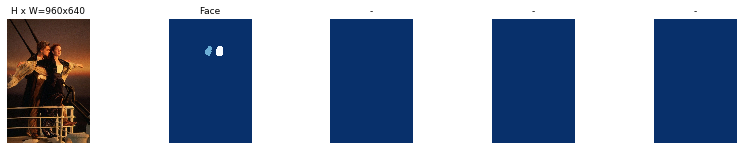

In [0]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 1)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Prepare the Model

### Create Model

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Which weights to start with?
init_with = 'coco'  # imagenet, coco, or last

if init_with == 'imagenet':
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == 'coco':
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH,
              by_name=True,
              exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])
elif init_with == 'last':
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers='all'` to train all layers.

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train,
      dataset_val, 
      learning_rate=config.LEARNING_RATE, 
      epochs=50, 
      layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/Mask_RCNN/logs/face20200223T1303/mask_rcnn_face_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/50
100/100 [==============================] - 103s 1s/step - loss: 1.9984 - rpn_class_loss: 0.0610 - rpn_bbox_loss: 0.6341 - mrcnn_class_loss: 0.1665 - mrcnn_bbox_loss: 0.6122 - mrcnn_mask_loss: 0.5247 - val_loss: 1.8457 - val_rpn_class_loss: 0.0469 - val_rpn_bbox_loss: 0.7327 - val_mrcnn_class_loss: 0.2094 - val_mrcnn_bbox_loss: 0.4870 - val_mrcnn_mask_loss: 0.3698

Epoch 2/50
100/100 [==============================] - 63s 628ms/step - loss: 1.4218 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.3754 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.5084 - mrcnn_mask_loss: 0.3943 - val_loss: 1.0692 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.1805 - val_mrcnn_class_loss: 0.0686 - val_mrcnn_bbox_loss: 0.4388 - val_mrcnn_mask_loss: 0.3704
Epoch 3/50
100/100 [==============================] - 63s 635ms/step - loss: 1.2601 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.3739 - mrcnn_class_loss: 0.1334 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.3313 - val_loss: 1.0013 - val_rpn_

In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, 
      dataset_val, 
      learning_rate=config.LEARNING_RATE / 10,
      epochs=30, 
      layers='all')

## Detection

In [0]:
class InferenceConfig(FaceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
              config=inference_config,
              model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, "mask_rcnn_face_0030.h5")
model_path = model.find_last()

# Load trained weights
print('Loading weights from {}'.format(model_path))
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from /content/Mask_RCNN/logs/face20200223T1303/mask_rcnn_face_0050.h5
Re-starting from epoch 50


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (6,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (6, 4)                min:   48.00000  max:  880.00000  int32
gt_mask                  shape: (1024, 1024, 6)       min:    0.00000  max:    1.00000  uint8


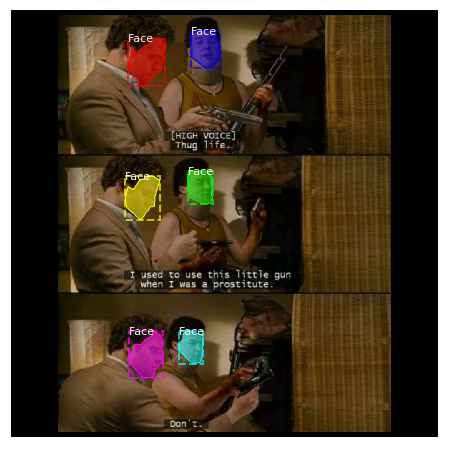

In [0]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log('original_image', original_image)
log('image_meta', image_meta)
log('gt_class_id', gt_class_id)
log('gt_bbox', gt_bbox)
log('gt_mask', gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  132.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


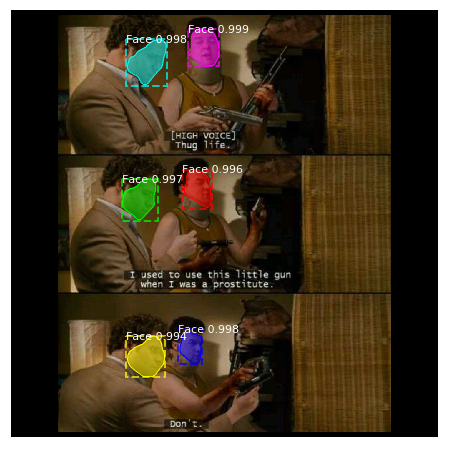

In [0]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, 
              r['rois'], 
              r['masks'],
              r['class_ids'], 
              dataset_val.class_names, 
              r['scores'], 
              ax=get_ax())

## Evaluation

In [0]:
# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = model.find_last()

# Load trained weights
print('Loading weights from {}'.format(model_path))
model.load_weights(model_path, by_name=True)

Loading weights from /content/Mask_RCNN/logs/face20200223T1303/mask_rcnn_face_0050.h5
Re-starting from epoch 50


### Compute VOC-Style mAP

In [0]:
# Running on all val/test images.
def compute_map(dataset):
  image_ids = dataset.image_ids
  AP = []
  iou_thresholds = np.arange(0.5, 1.0, 0.05)
  for image_id in image_ids:
      # Load image and ground truth data
      image, image_meta, gt_class_id, gt_bbox, gt_mask =\
          modellib.load_image_gt(dataset, inference_config, image_id, use_mini_mask=False)
      # Run object detection
      results = model.detect([image], verbose=0)
      r = results[0]
      # Compute AP
      """Compute AP over a range or IoU thresholds. Default range is 0.5-0.95."""
      # Default is 0.5 to 0.95 with increments of 0.05 
      ap = utils.compute_ap_range(gt_bbox, 
                     gt_class_id, 
                     gt_mask,
                     r['rois'], 
                     r['class_ids'], 
                     r['scores'], 
                     r['masks'], 
                     verbose=0)
      AP.append(ap)
  AP = np.array(AP).mean()
  print('AP @{:.2f}:{:.2f}:\t {:.3f}'.format(iou_thresholds[0], iou_thresholds[-1], AP))
  return None

In [0]:
compute_map(dataset_val)

AP @0.50:0.95:	 0.706


# Pixelate Images

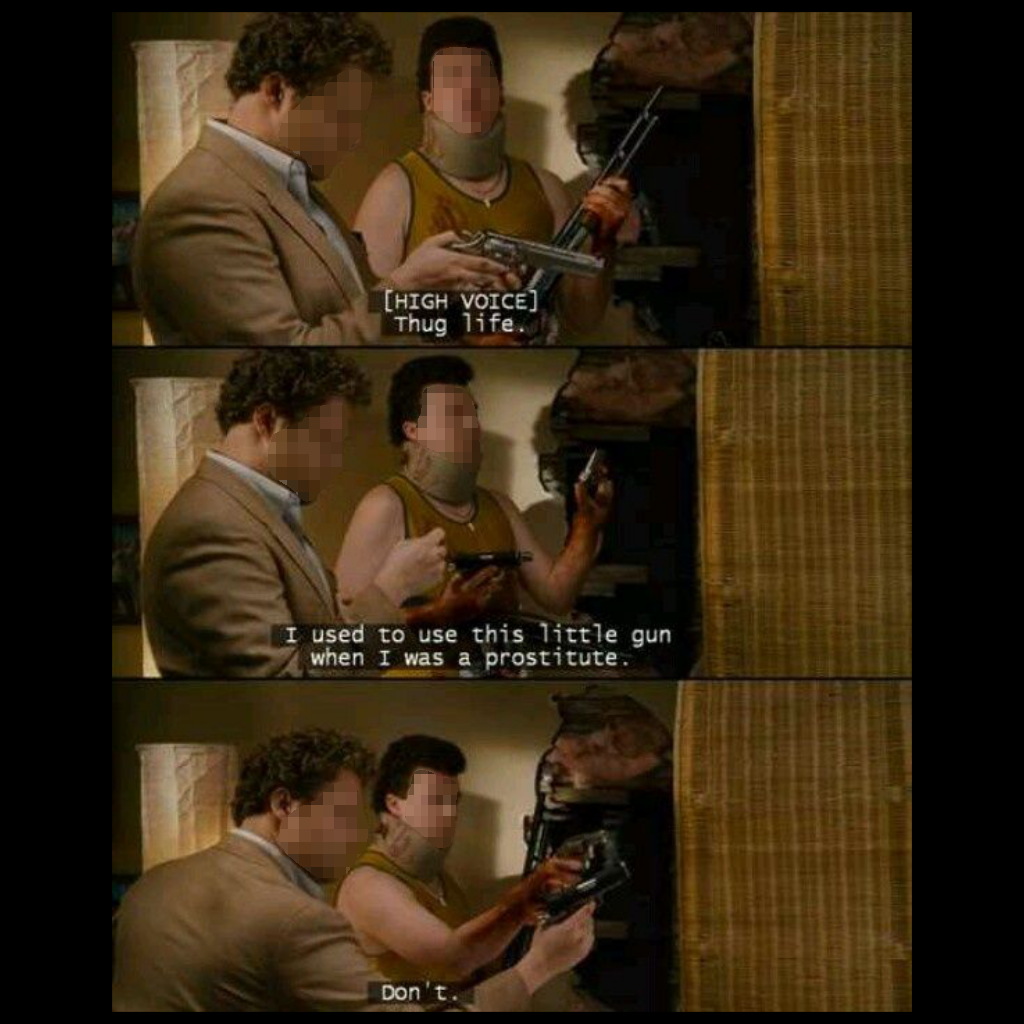

In [0]:
from PIL import Image

im = Image.fromarray(original_image)
im.save('original_image.png')
original_img = Image.open('original_image.png')
img = original_img.copy()
image = np.array(img)
mask_area = r['masks'].astype(int)

for num_instance in range(r['rois'].shape[0]):
  face_box = r['rois'][num_instance, :]
  face_position = np.array([face_box[1], face_box[0], face_box[3], face_box[2]])
  face_area = img.crop(face_position)
  # Resize smoothly down to 8x8 pixels
  temp = face_area.resize((8, 8), resample=Image.BILINEAR)
  # Scale back up using NEAREST to original size
  face_new = temp.resize(face_area.size, Image.NEAREST)
  img.paste(face_new, face_position)
  img_bbox = np.array(img)
  for i in range(r['rois'].shape[0]):
    points = np.argwhere(mask_area[:, :, i] == 1)
    for j in range(points.shape[0]):
      image[points[j, 0], points[j, 1]] = img_bbox[points[j, 0], points[j, 1]]

im = Image.fromarray(image)
im.save('pixelated_image.png')
pixelated_image = Image.open('pixelated_image.png')
pixelated_image

#Tensorboard

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2020-02-23 14:00:19--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.229.196.117, 34.238.36.128, 52.70.189.149, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.229.196.117|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  61.2MB/s    in 0.2s    

2020-02-23 14:00:19 (61.2 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
LOG_DIR = '/content/Mask_RCNN/logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://51665145.ngrok.io
